In [ ]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import umap

plt.rcdefaults()

# AB Manifold Analysis

Analysis notebook for bidirectional A↔B association experiments, exploring neural manifolds through dimensionality reduction and alignment techniques.

## 1. Data Loading

In [19]:
# This run is from the "ab_small.json" config
RUNS_PATH = Path('./runs/ab_manifold/20251207-141152/')
TRIAL     = 'trial_000.npz'

data = np.load(RUNS_PATH / TRIAL, allow_pickle=True)

# If record_dense = True, then:
# - The following are the binary neural activity matrices for the 2 brain regions
# - Shape of each is (T, N), where T = # timesteps, N = # neurons in region
A_dense = data["A_dense"]
B_dense = data["B_dense"]

# Get labels for each region (what action occured at each timestemp)
A_stages = np.array(data["A_stages"], dtype = str)
B_stages = np.array(data["B_stages"], dtype = str)

In [20]:
def stage_to_phase(stage: str) -> str:
    """Convert detailed stage labels to coarse phase labels."""
    if stage == "init_pair" or stage.startswith("stabilize_"):
        return "independent"
    if stage == "seed_A_to_B" or stage.startswith("A_to_B_recur_"):
        return "A_to_B"
    if stage == "seed_B_to_A" or stage.startswith("B_to_A_recur_"):
        return "B_to_A"
    return "other"

# Make coarse versions of the stages
A_phases = np.array([stage_to_phase(s) for s in A_stages], dtype=str)
B_phases = np.array([stage_to_phase(s) for s in B_stages], dtype=str)

In [21]:
# Get rows for ONLY stimA --> A and stimB --> B projections 
mask_indep_A = A_phases == "independent"
mask_indep_B = B_phases == "independent"

A_indep = A_dense[mask_indep_A]
B_indep = B_dense[mask_indep_B]

# Get rows for ONLY A --> B and B --> A projections
mask_assoc_A = (A_phases == "A_to_B") | (A_phases == "B_to_A")
mask_assoc_B = (B_phases == "A_to_B") | (B_phases == "B_to_A")

A_assoc = A_dense[mask_assoc_A]
B_assoc = B_dense[mask_assoc_B]

## 2. Utility Functions

In [22]:
def joint_embed_AB(A_mat, B_mat, n_components=3, method="pca", random_state=0):
    """
    Create joint embedding of regions A and B by concatenating activity in feature space.
    
    This creates a block structure where A neurons occupy the first half of features
    and B neurons occupy the second half, allowing both regions to be embedded together
    while preserving their identity.
    """
    assert A_mat.shape == B_mat.shape
    T, n = A_mat.shape

    X_A = np.concatenate([A_mat, np.zeros_like(A_mat)], axis=1)  # (T, 2n)
    X_B = np.concatenate([np.zeros_like(B_mat), B_mat], axis=1)  # (T, 2n)
    X = np.vstack([X_A, X_B])                                    # (2T, 2n)

    area_labels = np.array(["A"] * T + ["B"] * T, dtype=str)

    if method == "pca":
        model = PCA(n_components=n_components, random_state=random_state)
    else:
        model = umap.UMAP(n_components=n_components, random_state=random_state)

    embedding = model.fit_transform(X.astype(float))
    return embedding, area_labels


def embed_single(mat, n_components=3, method="pca", random_state=0):
    """
    Embed a single region's activity matrix using PCA or UMAP.
    """
    if method == "pca":
        model = PCA(n_components=n_components, random_state=random_state)
    else:
        model = umap.UMAP(n_components=n_components, random_state=random_state)
    
    embedding = model.fit_transform(mat.astype(float))
    return embedding

## 3. Visualization Functions

In [23]:
def compare_manifolds_side_by_side(
    data_before,
    data_after,
    labels_before,
    labels_after,
    title_before="Before",
    title_after="After",
    method="umap",
    n_components=3,
    random_state=42,
    figsize=(16, 6),
    color_before="Blues",
    color_after="Reds",
):
    """
    Create side-by-side comparison of neural manifolds from two different phases.
    
    Parameters
    ----------
    data_before : array, shape (T1, n)
        Neural activity matrix from first phase.
    data_after : array, shape (T2, n)
        Neural activity matrix from second phase.
    labels_before : array, shape (T1,)
        Stage labels for first phase.
    labels_after : array, shape (T2,)
        Stage labels for second phase.
    title_before : str
        Title for left panel.
    title_after : str
        Title for right panel.
    method : {"pca", "umap"}
        Dimensionality reduction method.
    n_components : int
        Number of embedding dimensions.
    random_state : int
        Random seed for reproducibility.
    figsize : tuple
        Figure size (width, height).
    color_before : str
        Matplotlib colormap name for first phase.
    color_after : str
        Matplotlib colormap name for second phase.
    
    Returns
    -------
    fig : matplotlib figure
        The generated figure.
    (embedding_before, embedding_after) : tuple of arrays
        The computed embeddings for both phases.
    """
    # Compute embeddings
    embedding_before = embed_single(
        data_before, method=method, n_components=n_components, random_state=random_state
    )
    embedding_after = embed_single(
        data_after, method=method, n_components=n_components, random_state=random_state
    )
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # -------------------- Left Panel: Before -------------------- #
    ax1 = axes[0]
    unique_stages_before = np.unique(labels_before)
    cmap_before = plt.get_cmap(color_before)
    
    for idx, stage in enumerate(unique_stages_before):
        mask = labels_before == stage
        color = cmap_before(0.4 + 0.6 * idx / max(len(unique_stages_before) - 1, 1))
        ax1.scatter(
            embedding_before[mask, 0],
            embedding_before[mask, 1],
            s=50, alpha=0.7, color=color, label=stage,
            edgecolors='black', linewidths=0.5
        )
    
    # Add trajectory line
    ax1.plot(embedding_before[:, 0], embedding_before[:, 1],
             '-', alpha=0.3, linewidth=1.5, zorder=0, 
             color=cmap_before(0.6))
    
    # Mark start and end
    ax1.scatter(embedding_before[0, 0], embedding_before[0, 1],
                s=250, marker='*', color='green', edgecolors='black',
                linewidths=2, label='Start', zorder=10)
    ax1.scatter(embedding_before[-1, 0], embedding_before[-1, 1],
                s=250, marker='s', color=cmap_before(0.9), edgecolors='black',
                linewidths=2, label='End', zorder=10)
    
    ax1.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax1.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax1.set_title(title_before, fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=9, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='datalim')
    
    # -------------------- Right Panel: After -------------------- #
    ax2 = axes[1]
    unique_stages_after = np.unique(labels_after)
    cmap_after = plt.get_cmap(color_after)
    
    for idx, stage in enumerate(unique_stages_after):
        mask = labels_after == stage
        color = cmap_after(0.4 + 0.6 * idx / max(len(unique_stages_after) - 1, 1))
        ax2.scatter(
            embedding_after[mask, 0],
            embedding_after[mask, 1],
            s=50, alpha=0.7, color=color, label=stage,
            edgecolors='black', linewidths=0.5
        )
    
    # Add trajectory line
    ax2.plot(embedding_after[:, 0], embedding_after[:, 1],
             '-', alpha=0.3, linewidth=1.5, zorder=0,
             color=cmap_after(0.6))
    
    # Mark start and end
    ax2.scatter(embedding_after[0, 0], embedding_after[0, 1],
                s=250, marker='*', color='orange', edgecolors='black',
                linewidths=2, label='Start', zorder=10)
    ax2.scatter(embedding_after[-1, 0], embedding_after[-1, 1],
                s=250, marker='X', color=cmap_after(0.9), edgecolors='black',
                linewidths=2, label='End', zorder=10)
    
    ax2.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax2.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax2.set_title(title_after, fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=9, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title_before}: {len(embedding_before)} time points")
    print(f"{title_after}:  {len(embedding_after)} time points")
    
    return fig, (embedding_before, embedding_after)


### 3.1 Single Region Comparisons

Compare individual brain regions (A and B) across experimental phases to visualize how their neural manifolds evolve during stabilization vs. association learning.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



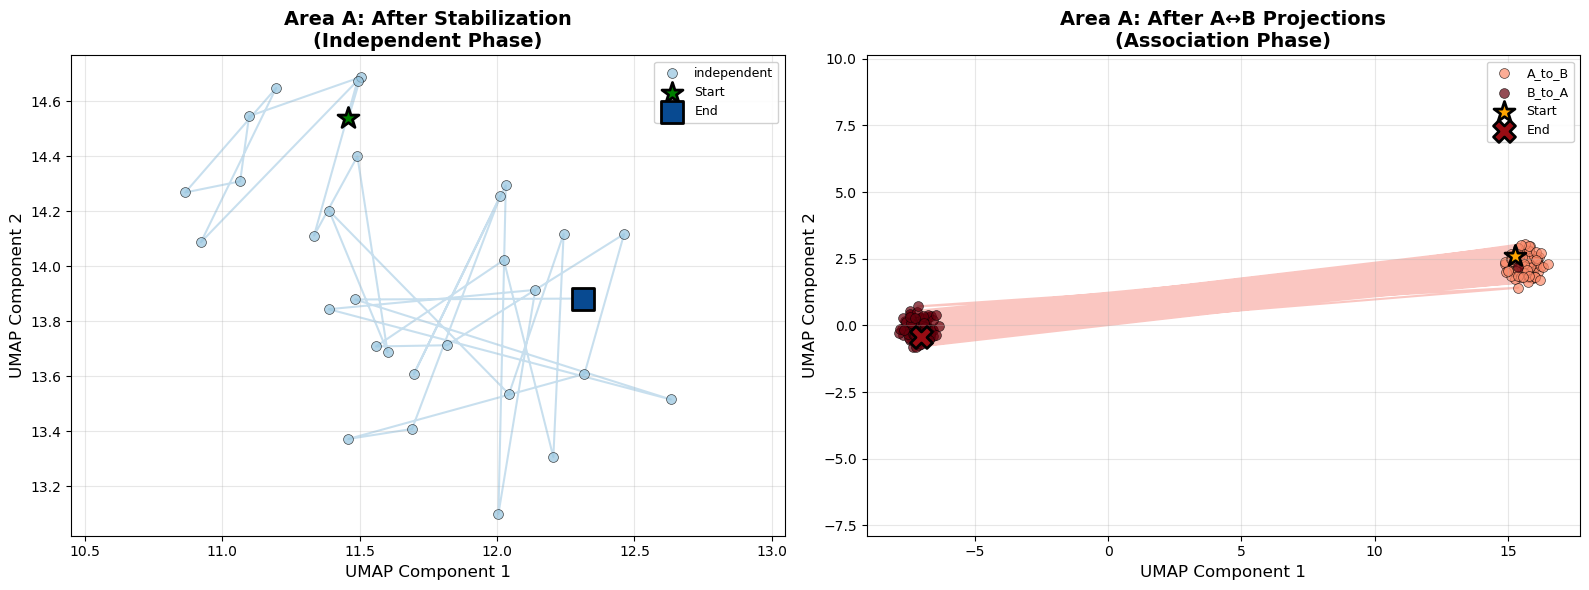

Area A: After Stabilization
(Independent Phase): 31 time points
Area A: After A↔B Projections
(Association Phase):  202 time points


In [ ]:
# Compare Area A: Independent vs Association Phase
fig_A, (emb_A_before, emb_A_after) = compare_manifolds_side_by_side(
    data_before   = A_indep,
    data_after    = A_assoc,
    labels_before = A_phases[mask_indep_A],
    labels_after  = A_phases[mask_assoc_A],
    n_components  = 5,
    method        = "umap",
    title_before  = "Area A: After Stabilization\n(Independent Phase)",
    title_after   = "Area A: After A↔B Projections\n(Association Phase)",
    color_before  = "Blues",
    color_after   = "Reds",
)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



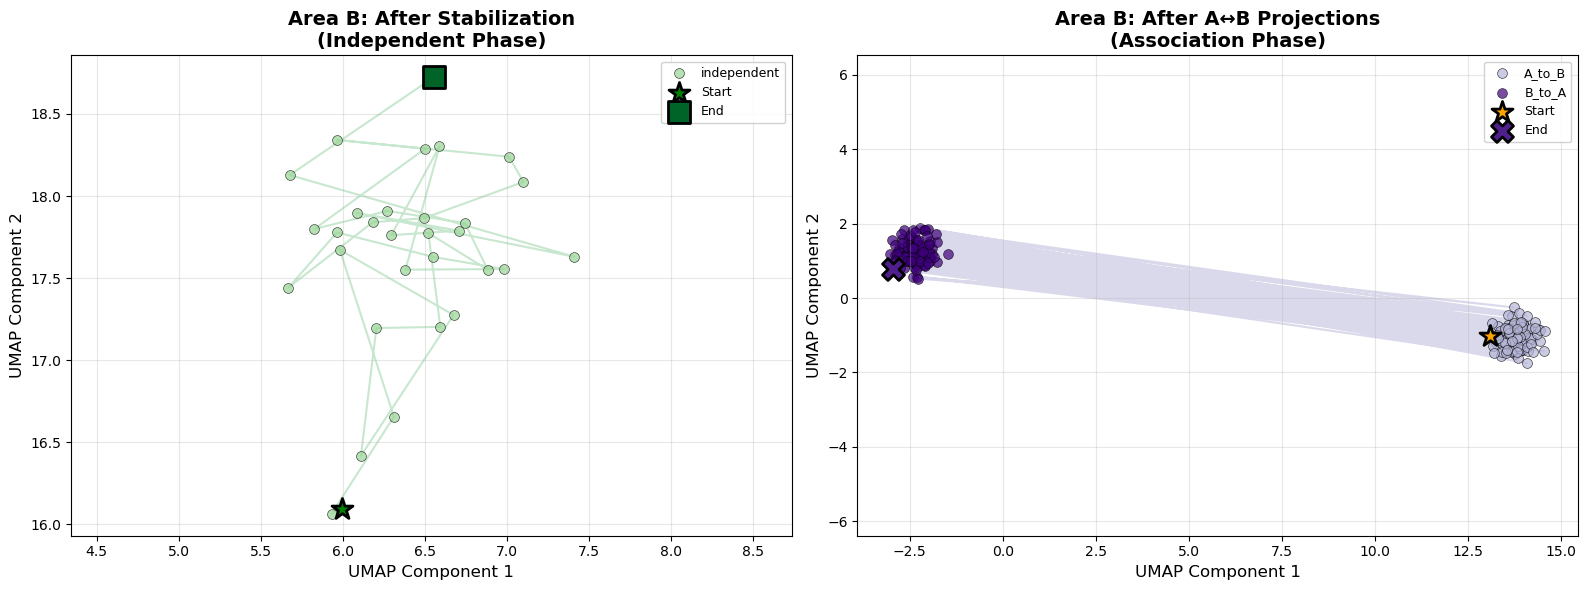

Area B: After Stabilization
(Independent Phase): 31 time points
Area B: After A↔B Projections
(Association Phase):  202 time points


In [38]:
# Compare Area B: Independent vs Association Phase
fig_B, (emb_B_before, emb_B_after) = compare_manifolds_side_by_side(
    data_before   = B_indep,
    data_after    = B_assoc,
    labels_before = B_phases[mask_indep_B],
    labels_after  = B_phases[mask_assoc_B],
    n_components  = 5,
    method        = "umap",
    title_before  = "Area B: After Stabilization\n(Independent Phase)",
    title_after   = "Area B: After A↔B Projections\n(Association Phase)",
    color_before  = "Greens",
    color_after   = "Purples",
)

## 4. Analysis: Joint A & B Embeddings

In [26]:
def compare_joint_embeddings_side_by_side(
    A_before: np.ndarray,
    B_before: np.ndarray,
    A_after: np.ndarray,
    B_after: np.ndarray,
    method: str = 'umap',
    n_components: int = 3,
    random_state: int = 42,
    figsize: tuple = (16, 7),
    title_before: str = "Independent Phase:\nAreas A & B (Separate Manifolds)",
    title_after: str = "Association Phase:\nAreas A & B (After A↔B Projections)",
    colors_before: tuple = ("steelblue", "coral"),
    colors_after: tuple = ("darkblue", "darkred"),
):
    """
    Create side-by-side comparison of joint A & B embeddings from two different phases.
    
    Parameters
    ----------
    A_before : array, shape (T1, n)
        Neural activity matrix for region A in first phase.
    B_before : array, shape (T1, n)
        Neural activity matrix for region B in first phase.
    A_after : array, shape (T2, n)
        Neural activity matrix for region A in second phase.
    B_after : array, shape (T2, n)
        Neural activity matrix for region B in second phase.
    method : {"pca", "umap"}
        Dimensionality reduction method.
    n_components : int
        Number of embedding dimensions.
    random_state : int
        Random seed for reproducibility.
    figsize : tuple
        Figure size (width, height).
    title_before : str
        Title for left panel.
    title_after : str
        Title for right panel.
    colors_before : tuple of str
        Colors for (A, B) in before phase.
    colors_after : tuple of str
        Colors for (A, B) in after phase.
    
    Returns
    -------
    fig : matplotlib figure
        The generated figure.
    results : dict
        Dictionary containing:
        - embedding_before: joint embedding for before phase
        - embedding_after: joint embedding for after phase
        - area_labels_before: labels ('A' or 'B') for before phase
        - area_labels_after: labels ('A' or 'B') for after phase
        - separation_before: mean A↔B distance in before phase
        - separation_after: mean A↔B distance in after phase
    """
    from scipy.spatial.distance import cdist
    
    # Compute joint embeddings
    embedding_before, area_labels_before = joint_embed_AB(
        A_before, B_before, method=method, n_components=n_components, random_state=random_state
    )
    embedding_after, area_labels_after = joint_embed_AB(
        A_after, B_after, method=method, n_components=n_components, random_state=random_state
    )
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # -------------------- Left: Before Phase -------------------- #
    ax1 = axes[0]
    T_before = len(area_labels_before) // 2
    color_A_before, color_B_before = colors_before
    
    for area, color in [("A", color_A_before), ("B", color_B_before)]:
        mask = area_labels_before == area
        ax1.scatter(
            embedding_before[mask, 0],
            embedding_before[mask, 1],
            s=60, alpha=0.7, color=color, label=f"Area {area}",
            edgecolors='black', linewidths=0.8
        )
    
    # Add trajectory lines for each area
    A_mask_before = area_labels_before == "A"
    B_mask_before = area_labels_before == "B"
    
    ax1.plot(embedding_before[A_mask_before, 0], embedding_before[A_mask_before, 1],
             '-', color=color_A_before, alpha=0.3, linewidth=1.5, zorder=0)
    ax1.plot(embedding_before[B_mask_before, 0], embedding_before[B_mask_before, 1],
             '-', color=color_B_before, alpha=0.3, linewidth=1.5, zorder=0)
    
    # Mark start points
    ax1.scatter(embedding_before[0, 0], embedding_before[0, 1],
                s=300, marker='*', color='green', edgecolors='black',
                linewidths=2, label='Start (A)', zorder=10)
    ax1.scatter(embedding_before[T_before, 0], embedding_before[T_before, 1],
                s=300, marker='*', color='lime', edgecolors='black',
                linewidths=2, label='Start (B)', zorder=10)
    
    ax1.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax1.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax1.set_title(title_before, fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='datalim')
    
    # -------------------- Right: After Phase -------------------- #
    ax2 = axes[1]
    T_after = len(area_labels_after) // 2
    color_A_after, color_B_after = colors_after
    
    for area, color in [("A", color_A_after), ("B", color_B_after)]:
        mask = area_labels_after == area
        ax2.scatter(
            embedding_after[mask, 0],
            embedding_after[mask, 1],
            s=60, alpha=0.7, color=color, label=f"Area {area}",
            edgecolors='black', linewidths=0.8
        )
    
    # Add trajectory lines for each area
    A_mask_after = area_labels_after == "A"
    B_mask_after = area_labels_after == "B"
    
    ax2.plot(embedding_after[A_mask_after, 0], embedding_after[A_mask_after, 1],
             '-', color=color_A_after, alpha=0.3, linewidth=1.5, zorder=0)
    ax2.plot(embedding_after[B_mask_after, 0], embedding_after[B_mask_after, 1],
             '-', color=color_B_after, alpha=0.3, linewidth=1.5, zorder=0)
    
    # Mark start points
    ax2.scatter(embedding_after[0, 0], embedding_after[0, 1],
                s=300, marker='*', color='orange', edgecolors='black',
                linewidths=2, label='Start (A)', zorder=10)
    ax2.scatter(embedding_after[T_after, 0], embedding_after[T_after, 1],
                s=300, marker='*', color='yellow', edgecolors='black',
                linewidths=2, label='Start (B)', zorder=10)
    
    # Mark end points
    ax2.scatter(embedding_after[T_after-1, 0], embedding_after[T_after-1, 1],
                s=200, marker='X', color='purple', edgecolors='black',
                linewidths=2, label='End (A)', zorder=10)
    ax2.scatter(embedding_after[-1, 0], embedding_after[-1, 1],
                s=200, marker='X', color='magenta', edgecolors='black',
                linewidths=2, label='End (B)', zorder=10)
    
    ax2.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax2.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax2.set_title(title_after, fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print manifold separation statistics
    def compute_separation(embedding, labels):
        """Compute mean distance between A and B manifolds."""
        A_points = embedding[labels == "A"]
        B_points = embedding[labels == "B"]
        distances = cdist(A_points, B_points, metric='euclidean')
        return distances.mean()
    
    sep_before = compute_separation(embedding_before, area_labels_before)
    sep_after = compute_separation(embedding_after, area_labels_after)
    
    print(f"Manifold Separation (Mean A↔B Distance):")
    print(f"  {title_before.split(':')[0]}: {sep_before:.4f}")
    print(f"  {title_after.split(':')[0]}:  {sep_after:.4f}")
    print(f"  Change:            {sep_after - sep_before:+.4f} ({(sep_after/sep_before - 1)*100:+.1f}%)")
    
    results = {
        'embedding_before': embedding_before,
        'embedding_after': embedding_after,
        'area_labels_before': area_labels_before,
        'area_labels_after': area_labels_after,
        'separation_before': sep_before,
        'separation_after': sep_after,
    }
    
    return fig, results


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



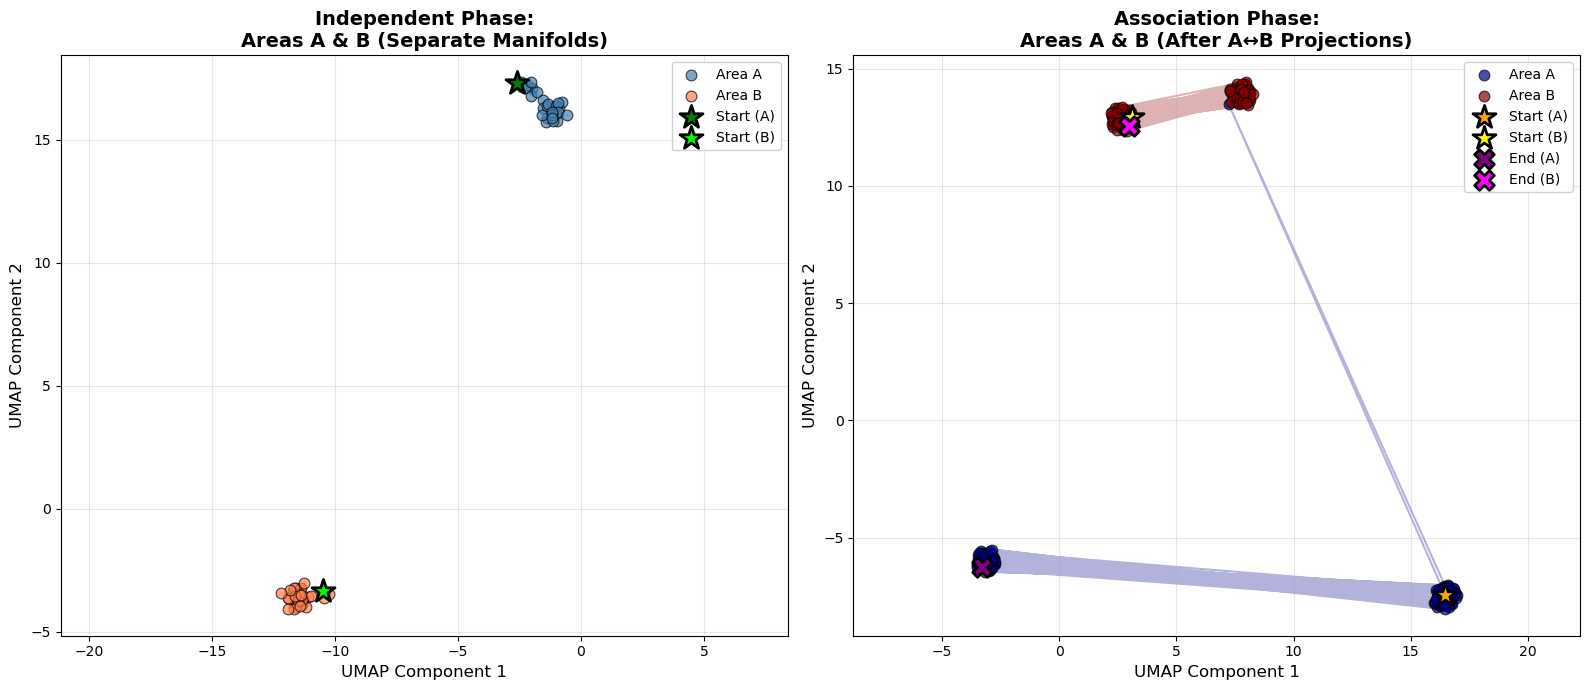

Manifold Separation (Mean A↔B Distance):
  Independent Phase: 32.6339
  Association Phase:  23.9246
  Change:            -8.7093 (-26.7%)


In [39]:
# Compare joint A & B embeddings across phases
fig, results = compare_joint_embeddings_side_by_side(
    A_before     = A_indep,
    B_before     = B_indep,
    A_after      = A_assoc,
    B_after      = B_assoc,
    n_components = 5,
    method       = 'umap'
)

## 5. Analysis: UMAP + CCA Alignment

In [28]:
def plot_umap_cca_alignment(
    X_A: np.ndarray,
    X_B: np.ndarray,
    n_umap_components=10,
    n_cca_components=3,
    use_joint_umap=False,
    random_state=42,
    title="UMAP + CCA Alignment: A vs B (Association Phase)",
    width=1000,
    height=800,
    point_size=5,
    alpha=0.7,
):
    """
    Align and visualize brain region manifolds using UMAP + CCA with interactive Plotly.
    
    Pipeline:
    1. Embed each region's activity with UMAP to reduce dimensionality
       - If use_joint_umap=True: Use joint UMAP on concatenated A & B data
       - If use_joint_umap=False: Separate UMAP for each region
    2. Apply CCA to find aligned canonical variates between the two regions
    3. Plot the aligned manifolds (1D, 2D, or 3D) or report statistics (>3D)
    
    Parameters
    ----------
    X_A : array, shape (T, n_neurons_A)
        Neural activity matrix for region A.
    X_B : array, shape (T, n_neurons_B)
        Neural activity matrix for region B (same T).
    n_umap_components : int
        Number of UMAP dimensions to extract before CCA.
    n_cca_components : int
        Number of canonical components (must be <= n_umap_components).
        - 1: 1D line plot
        - 2: 2D scatter plot
        - 3: 3D scatter plot
        - >3: No plot, only statistics
    use_joint_umap : bool
        If True, use joint UMAP on concatenated A & B data.
        If False, use separate UMAP for each region.
    random_state : int
        Random seed for reproducibility.
    title : str
        Plot title.
    width : int
        Figure width in pixels.
    height : int
        Figure height in pixels.
    point_size : float
        Marker size for scatter points.
    alpha : float
        Point transparency.
    
    Returns
    -------
    Z_A_cca : array, shape (T, n_cca_components)
        CCA-transformed coordinates for region A.
    Z_B_cca : array, shape (T, n_cca_components)
        CCA-transformed coordinates for region B.
    cca : CCA object
        Fitted CCA model.
    fig : plotly.graph_objects.Figure or None
        Interactive Plotly figure (None if n_cca_components > 3).
    """
    assert X_A.shape[0] == X_B.shape[0], "A and B must have same number of timepoints"
    T = X_A.shape[0]
    
    print(f"Input shapes: A={X_A.shape}, B={X_B.shape}")
    
    # Step 1: UMAP embedding for each region
    print(f"Running UMAP with {n_umap_components} components (joint={use_joint_umap})...")
    
    if use_joint_umap:
        # Joint UMAP on concatenated data
        umap_model = umap.UMAP(n_components=n_umap_components, random_state=random_state)
        X_joint = np.vstack([X_A.astype(float), X_B.astype(float)])
        Z_joint = umap_model.fit_transform(X_joint)
        Z_A_umap = Z_joint[:T]
        Z_B_umap = Z_joint[T:]
    else:
        # Separate UMAP for each region
        umap_A = umap.UMAP(n_components=n_umap_components, random_state=random_state)
        umap_B = umap.UMAP(n_components=n_umap_components, random_state=random_state)
        Z_A_umap = umap_A.fit_transform(X_A.astype(float))
        Z_B_umap = umap_B.fit_transform(X_B.astype(float))
    
    print(f"UMAP embeddings: A={Z_A_umap.shape}, B={Z_B_umap.shape}")
    
    # Step 2: CCA to align the UMAP embeddings
    print(f"Running CCA with {n_cca_components} components...")
    cca = CCA(n_components=n_cca_components)
    Z_A_cca, Z_B_cca = cca.fit_transform(Z_A_umap, Z_B_umap)
    
    print(f"CCA-aligned shapes: A={Z_A_cca.shape}, B={Z_B_cca.shape}")
    
    # Compute canonical correlations
    correlations = []
    for i in range(n_cca_components):
        corr = np.corrcoef(Z_A_cca[:, i], Z_B_cca[:, i])[0, 1]
        correlations.append(corr)
    
    print(f"Canonical correlations: {correlations}")
    
    # Step 3: Visualization based on dimensionality
    if n_cca_components > 3:
        print(f"\n{n_cca_components}D visualization not supported. Reporting statistics only.")
        print("\nCanonical Correlation Statistics:")
        for i, corr in enumerate(correlations):
            print(f"  CC{i+1}: {corr:.4f}")
        print(f"  Mean: {np.mean(correlations):.4f}")
        print(f"  Std:  {np.std(correlations):.4f}")
        return Z_A_cca, Z_B_cca, cca, None
    
    # Create interactive visualization
    fig = go.Figure()
    
    if n_cca_components == 1:
        # 1D line plot
        time_indices = np.arange(T)
        
        fig.add_trace(go.Scatter(
            x=time_indices, y=Z_A_cca[:, 0],
            mode='lines+markers',
            line=dict(color='steelblue', width=2),
            marker=dict(size=point_size, opacity=alpha),
            name='Area A',
            hovertemplate='Time: %{x}<br>CC1: %{y:.3f}<extra></extra>'
        ))
        
        fig.add_trace(go.Scatter(
            x=time_indices, y=Z_B_cca[:, 0],
            mode='lines+markers',
            line=dict(color='coral', width=2),
            marker=dict(size=point_size, opacity=alpha),
            name='Area B',
            hovertemplate='Time: %{x}<br>CC1: %{y:.3f}<extra></extra>'
        ))
        
        # Start/end markers
        for area, data, colors in [('A', Z_A_cca, ('green', 'darkblue')), 
                                     ('B', Z_B_cca, ('lime', 'darkred'))]:
            fig.add_trace(go.Scatter(
                x=[0], y=[data[0, 0]],
                mode='markers',
                marker=dict(size=12, symbol='diamond', color=colors[0], 
                          line=dict(width=2, color='black')),
                name=f'Start ({area})',
                hovertemplate=f'Start {area}<br>CC1: %{{y:.3f}}<extra></extra>'
            ))
            fig.add_trace(go.Scatter(
                x=[T-1], y=[data[-1, 0]],
                mode='markers',
                marker=dict(size=10, symbol='cross', color=colors[1],
                          line=dict(width=2, color='black')),
                name=f'End ({area})',
                hovertemplate=f'End {area}<br>CC1: %{{y:.3f}}<extra></extra>'
            ))
        
        corr_text = f"CC1: {correlations[0]:.3f}"
        fig.update_layout(
            title=dict(text=f"{title}<br><sub>{corr_text}</sub>", font=dict(size=16)),
            xaxis_title='Time Index',
            yaxis_title='CCA Component 1',
            width=width, height=height, showlegend=True,
            legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)', 
                       bordercolor='black', borderwidth=1)
        )
    
    elif n_cca_components == 2:
        # 2D scatter plot
        for area, data, color in [('A', Z_A_cca, 'steelblue'), ('B', Z_B_cca, 'coral')]:
            fig.add_trace(go.Scatter(
                x=data[:, 0], y=data[:, 1],
                mode='markers',
                marker=dict(size=point_size, color=color, opacity=alpha,
                          line=dict(width=0.5, color='black')),
                name=f'Area {area}',
                hovertemplate=f'Area {area}<br>CC1: %{{x:.3f}}<br>CC2: %{{y:.3f}}<extra></extra>'
            ))
        
        # Trajectories
        fig.add_trace(go.Scatter(
            x=Z_A_cca[:, 0], y=Z_A_cca[:, 1],
            mode='lines', line=dict(color='blue', width=2), opacity=0.3,
            name='A trajectory', hoverinfo='skip'
        ))
        fig.add_trace(go.Scatter(
            x=Z_B_cca[:, 0], y=Z_B_cca[:, 1],
            mode='lines', line=dict(color='coral', width=2), opacity=0.3,
            name='B trajectory', hoverinfo='skip'
        ))
        
        # Start/end markers
        markers = [
            (Z_A_cca[0], 'green', 'diamond', 'Start (A)'),
            (Z_B_cca[0], 'lime', 'diamond', 'Start (B)'),
            (Z_A_cca[-1], 'darkblue', 'cross', 'End (A)'),
            (Z_B_cca[-1], 'darkred', 'cross', 'End (B)')
        ]
        for data, color, symbol, name in markers:
            fig.add_trace(go.Scatter(
                x=[data[0]], y=[data[1]],
                mode='markers',
                marker=dict(size=12 if 'Start' in name else 10, symbol=symbol, 
                          color=color, line=dict(width=2, color='black')),
                name=name,
                hovertemplate=f'{name}<br>CC1: %{{x:.3f}}<br>CC2: %{{y:.3f}}<extra></extra>'
            ))
        
        corr_text = f"CC1: {correlations[0]:.3f} | CC2: {correlations[1]:.3f}"
        fig.update_layout(
            title=dict(text=f"{title}<br><sub>{corr_text}</sub>", font=dict(size=16)),
            xaxis_title='CCA Component 1', yaxis_title='CCA Component 2',
            width=width, height=height, showlegend=True,
            legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)',
                       bordercolor='black', borderwidth=1)
        )
    
    else:  # n_cca_components == 3
        # 3D scatter plot
        for area, data, color in [('A', Z_A_cca, 'steelblue'), ('B', Z_B_cca, 'coral')]:
            fig.add_trace(go.Scatter3d(
                x=data[:, 0], y=data[:, 1], z=data[:, 2],
                mode='markers',
                marker=dict(size=point_size, color=color, opacity=alpha,
                          line=dict(width=0.5, color='black')),
                name=f'Area {area}',
                hovertemplate=f'Area {area}<br>CC1: %{{x:.3f}}<br>CC2: %{{y:.3f}}<br>CC3: %{{z:.3f}}<extra></extra>'
            ))
        
        # Trajectories
        for area, data, color in [('A', Z_A_cca, 'blue'), ('B', Z_B_cca, 'coral')]:
            fig.add_trace(go.Scatter3d(
                x=data[:, 0], y=data[:, 1], z=data[:, 2],
                mode='lines', line=dict(color=color, width=3), opacity=0.3,
                name=f'{area} trajectory', hoverinfo='skip'
            ))
        
        # Start/end markers
        markers_3d = [
            (Z_A_cca[0], 'green', 'diamond', 'Start (A)'),
            (Z_B_cca[0], 'lime', 'diamond', 'Start (B)'),
            (Z_A_cca[-1], 'darkblue', 'cross', 'End (A)'),
            (Z_B_cca[-1], 'darkred', 'cross', 'End (B)')
        ]
        for data, color, symbol, name in markers_3d:
            fig.add_trace(go.Scatter3d(
                x=[data[0]], y=[data[1]], z=[data[2]],
                mode='markers',
                marker=dict(size=12 if 'Start' in name else 10, symbol=symbol,
                          color=color, line=dict(width=2, color='black')),
                name=name,
                hovertemplate=f'{name}<br>CC1: %{{x:.3f}}<br>CC2: %{{y:.3f}}<br>CC3: %{{z:.3f}}<extra></extra>'
            ))
        
        corr_text = f"CC1: {correlations[0]:.3f} | CC2: {correlations[1]:.3f} | CC3: {correlations[2]:.3f}"
        fig.update_layout(
            title=dict(text=f"{title}<br><sub>{corr_text}</sub>", font=dict(size=16)),
            scene=dict(
                xaxis_title='CCA Component 1',
                yaxis_title='CCA Component 2',
                zaxis_title='CCA Component 3',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
            ),
            width=width, height=height, showlegend=True,
            legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)',
                       bordercolor='black', borderwidth=1)
        )
    
    fig.show()
    return Z_A_cca, Z_B_cca, cca, fig

### 5.1 Single Phase Analysis

Examine CCA alignment between regions A and B during individual experimental phases. This reveals how well the two regions' activity patterns are correlated within each phase.

In [46]:
def compare_umap_cca_alignment_side_by_side(
    X_A_before: np.ndarray,
    X_B_before: np.ndarray,
    X_A_after: np.ndarray,
    X_B_after: np.ndarray,
    n_umap_components=10,
    n_cca_components=3,
    use_joint_umap=False,
    random_state=42,
    title_before="Before",
    title_after="After",
    figsize=(18, 8),
):
    """
    Create side-by-side 3D comparison of UMAP + CCA alignments from two phases.
    
    Parameters
    ----------
    X_A_before, X_B_before : arrays
        Neural activity matrices for regions A and B in first phase.
    X_A_after, X_B_after : arrays
        Neural activity matrices for regions A and B in second phase.
    n_umap_components : int
        Number of UMAP dimensions to extract before CCA.
    n_cca_components : int
        Number of canonical components (only 3D supported for side-by-side).
    use_joint_umap : bool
        If True, use joint UMAP on concatenated A & B data.
    random_state : int
        Random seed for reproducibility.
    title_before, title_after : str
        Titles for left and right panels.
    figsize : tuple
        Figure size (width, height) in inches.
    
    Returns
    -------
    fig : matplotlib figure
        The generated figure.
    results : dict
        Dictionary containing CCA results for both phases.
    """
    if n_cca_components != 3:
        raise ValueError("Side-by-side comparison only supports n_cca_components=3 (3D plots)")
    
    # Process both phases
    results = {}
    for phase_name, X_A, X_B in [('before', X_A_before, X_B_before), 
                                   ('after', X_A_after, X_B_after)]:
        assert X_A.shape[0] == X_B.shape[0], f"A and B must have same timepoints in {phase_name} phase"
        T = X_A.shape[0]
        
        # UMAP embedding
        if use_joint_umap:
            umap_model = umap.UMAP(n_components=n_umap_components, random_state=random_state)
            X_joint = np.vstack([X_A.astype(float), X_B.astype(float)])
            Z_joint = umap_model.fit_transform(X_joint)
            Z_A_umap = Z_joint[:T]
            Z_B_umap = Z_joint[T:]
        else:
            umap_A = umap.UMAP(n_components=n_umap_components, random_state=random_state)
            umap_B = umap.UMAP(n_components=n_umap_components, random_state=random_state)
            Z_A_umap = umap_A.fit_transform(X_A.astype(float))
            Z_B_umap = umap_B.fit_transform(X_B.astype(float))
        
        # CCA alignment
        cca = CCA(n_components=n_cca_components)
        Z_A_cca, Z_B_cca = cca.fit_transform(Z_A_umap, Z_B_umap)
        
        # Compute correlations
        correlations = [np.corrcoef(Z_A_cca[:, i], Z_B_cca[:, i])[0, 1] 
                       for i in range(n_cca_components)]
        
        results[phase_name] = {
            'Z_A_cca': Z_A_cca,
            'Z_B_cca': Z_B_cca,
            'cca': cca,
            'correlations': correlations,
            'T': T
        }
    
    # Create side-by-side 3D subplots
    fig = plt.figure(figsize=figsize)
    
    # Plot both phases
    for col, phase_name in enumerate(['before', 'after']):
        ax = fig.add_subplot(1, 2, col+1, projection='3d')
        data = results[phase_name]
        Z_A_cca = data['Z_A_cca']
        Z_B_cca = data['Z_B_cca']
        correlations = data['correlations']
        
        # Area A scatter
        ax.scatter(Z_A_cca[:, 0], Z_A_cca[:, 1], Z_A_cca[:, 2],
                  s=40, c='steelblue', alpha=0.7, edgecolors='black',
                  linewidths=0.5, label='Area A')
        
        # Area B scatter
        ax.scatter(Z_B_cca[:, 0], Z_B_cca[:, 1], Z_B_cca[:, 2],
                  s=40, c='coral', alpha=0.7, edgecolors='black',
                  linewidths=0.5, label='Area B')
        
        # Trajectories
        ax.plot(Z_A_cca[:, 0], Z_A_cca[:, 1], Z_A_cca[:, 2],
               color='blue', linewidth=2, alpha=0.3)
        ax.plot(Z_B_cca[:, 0], Z_B_cca[:, 1], Z_B_cca[:, 2],
               color='coral', linewidth=2, alpha=0.3)
        
        # Start/end markers
        ax.scatter([Z_A_cca[0, 0]], [Z_A_cca[0, 1]], [Z_A_cca[0, 2]],
                  s=150, marker='D', c='green', edgecolors='black',
                  linewidths=2, label='Start (A)', zorder=10)
        ax.scatter([Z_B_cca[0, 0]], [Z_B_cca[0, 1]], [Z_B_cca[0, 2]],
                  s=150, marker='D', c='lime', edgecolors='black',
                  linewidths=2, label='Start (B)', zorder=10)
        ax.scatter([Z_A_cca[-1, 0]], [Z_A_cca[-1, 1]], [Z_A_cca[-1, 2]],
                  s=120, marker='X', c='darkblue', edgecolors='black',
                  linewidths=2, label='End (A)', zorder=10)
        ax.scatter([Z_B_cca[-1, 0]], [Z_B_cca[-1, 1]], [Z_B_cca[-1, 2]],
                  s=120, marker='X', c='darkred', edgecolors='black',
                  linewidths=2, label='End (B)', zorder=10)
        
        # Labels and title
        ax.set_xlabel('CCA Component 1', fontsize=10)
        ax.set_ylabel('CCA Component 2', fontsize=10)
        ax.set_zlabel('CCA Component 3', fontsize=10)
        
        subtitle = (f"{title_before if col == 0 else title_after}\n"
                   f"CC1={correlations[0]:.3f}, CC2={correlations[1]:.3f}, CC3={correlations[2]:.3f}")
        ax.set_title(subtitle, fontsize=12, fontweight='bold')
        ax.legend(loc='upper left', fontsize=8, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.view_init(elev=20, azim=45)
    
    plt.suptitle('UMAP + CCA Alignment Comparison', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{title_before}:")
    print(f"  Canonical Correlations: CC1={results['before']['correlations'][0]:.4f}, "
          f"CC2={results['before']['correlations'][1]:.4f}, CC3={results['before']['correlations'][2]:.4f}")
    print(f"\n{title_after}:")
    print(f"  Canonical Correlations: CC1={results['after']['correlations'][0]:.4f}, "
          f"CC2={results['after']['correlations'][1]:.4f}, CC3={results['after']['correlations'][2]:.4f}")
    
    return fig, results

In [35]:
# Independent phase: UMAP + CCA alignment
Z_A_cca, Z_B_cca, cca_model, fig = plot_umap_cca_alignment(
    X_A               = A_indep,
    X_B               = B_indep,
    use_joint_umap    = False,
    n_umap_components = 5,
    n_cca_components  = 3,
    random_state      = 42,
    title             = "UMAP + CCA Alignment: A vs B (Independent Phase)",
    width             = 1000,
    height            = 800,
    point_size        = 5,
    alpha             = 0.7,
)

Input shapes: A=(31, 4096), B=(31, 4096)
Running UMAP with 5 components (joint=False)...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP embeddings: A=(31, 5), B=(31, 5)
Running CCA with 3 components...
CCA-aligned shapes: A=(31, 3), B=(31, 3)
Canonical correlations: [0.8819426963652879, 0.656575403626732, 0.4081228223382915]


In [ ]:
# Association phase: UMAP + CCA alignment
Z_A_cca, Z_B_cca, cca_model, fig = plot_umap_cca_alignment(
    X_A               = A_assoc,
    X_B               = B_assoc,
    use_joint_umap    = False,
    n_umap_components = 5,
    n_cca_components  = 3,
    random_state      = 42,
    title             = "UMAP + CCA Alignment: A vs B (Association Phase)",
    width             = 1000,
    height            = 800,
    point_size        = 5,
    alpha             = 0.7,
)

Input shapes: A=(202, 4096), B=(202, 4096)
Running UMAP with 5 components (joint=True)...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP embeddings: A=(202, 5), B=(202, 5)
Running CCA with 3 components...
CCA-aligned shapes: A=(202, 3), B=(202, 3)
Canonical correlations: [0.9894114238968207, 0.30396881775342066, 0.2001421524433937]


### 5.2 Control: Time-Shuffled Data

Test the robustness of observed correlations by time-shuffling region B's activity. This control helps determine whether CCA alignment reflects true temporal coupling or is merely an artifact of the analysis method.

In [36]:
rng = np.random.default_rng(0)
perm = rng.permutation(A_indep.shape[0])
B_indep_shuff = B_indep[perm]

# Independent phase: UMAP + CCA alignment
Z_A_cca, Z_B_cca, cca_model, fig = plot_umap_cca_alignment(
    X_A               = A_indep,
    X_B               = B_indep_shuff,
    use_joint_umap    = False,
    n_umap_components = 5,
    n_cca_components  = 3,
    random_state      = 42,
    title             = "UMAP + CCA Alignment: A vs B (time-shuffled) (Independent Phase)",
    width             = 1000,
    height            = 800,
    point_size        = 5,
    alpha             = 0.7,
)


Input shapes: A=(31, 4096), B=(31, 4096)
Running UMAP with 5 components (joint=False)...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP embeddings: A=(31, 5), B=(31, 5)
Running CCA with 3 components...
CCA-aligned shapes: A=(31, 3), B=(31, 3)
Canonical correlations: [0.6388420170424803, 0.6134806183336361, 0.3390616439571283]


### 5.3 Side-by-Side Phase Comparison

Direct visual comparison of CCA alignment across phases. This allows simultaneous viewing of how association learning affects the canonical correlation structure compared to the independent baseline.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



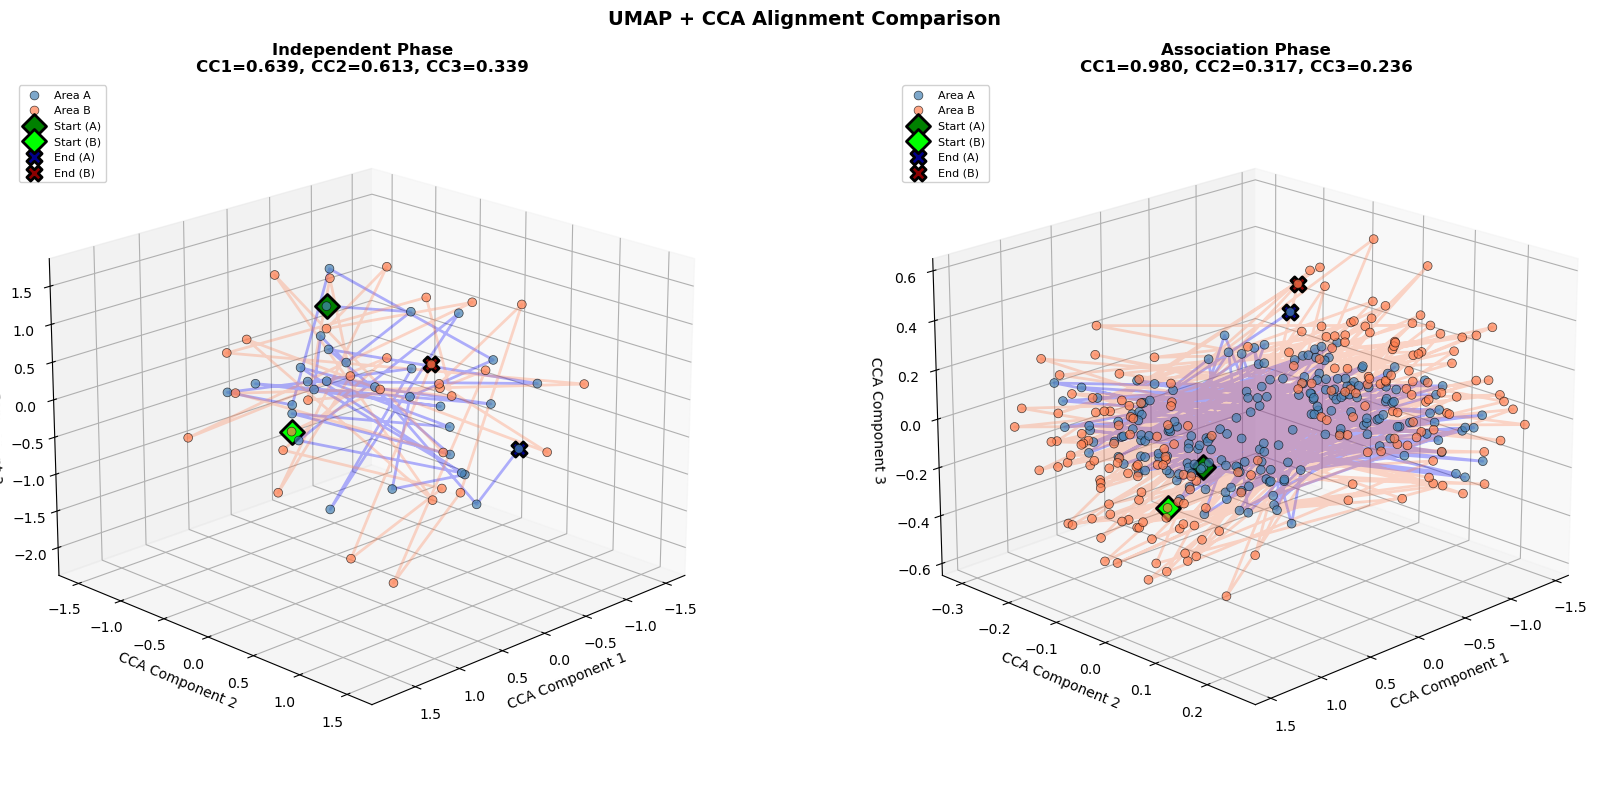


Independent Phase:
  Canonical Correlations: CC1=0.6388, CC2=0.6135, CC3=0.3391

Association Phase:
  Canonical Correlations: CC1=0.9804, CC2=0.3172, CC3=0.2360


In [47]:
# Compare independent vs association phase
fig, results = compare_umap_cca_alignment_side_by_side(
    X_A_before=A_indep,
    X_B_before=B_indep_shuff,
    X_A_after=A_assoc,
    X_B_after=B_assoc,
    n_umap_components=5,
    n_cca_components=3,
    use_joint_umap=False,
    title_before="Independent Phase",
    title_after="Association Phase"
)